In [215]:
from preprocess import preprocess_data_flat, get_isa_responses
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.dates as mdates

plt.style.use("seaborn-v0_8-white")
sns.set_style("white")
sns.set_palette("colorblind")
sns.set_context("paper", font_scale=1.2)

In [216]:
df_final = [preprocess_data_flat(x, 30, False) for x in ["1", "2"]]
x_final, y_final = [pd.concat([x[i] for x in df_final], ignore_index=True) for i in range(2)]
df = x_final.join(y_final)
df_means = df.iloc[:, np.r_[0:56, -1]]

In [149]:
def clean_column_names(columns, add_suffix=False):
    name_mapping = {
        'Mean': 'Mean',
        'Median': 'Median',
        'Variance': 'Variance',
        'Skewness': 'Skewness',
        'Kurtosis': 'Kurtosis',
        'RMS': 'RMS',
        'ZeroCrossings': 'Zero Crossings',
        'FFT_Mean': 'FFT Mean',
        'FFT_Std': 'FFT Std Dev',
        'FFT_Max': 'FFT Max',
        'STFT_Mean': 'STFT Mean',
        'STFT_Std': 'STFT Std Dev',
        'WPT_Mean': 'WPT Mean',
        'WPT_Std': 'WPT Std Dev',
        'ApEn': 'Approximate Entropy',
        'SampEn': 'Sample Entropy',
        'PeEn': 'Permutation Entropy',
        'DispEn': 'Dispersion Entropy',
        'TsEn': 'Time Series Entropy',
        'ReEn': 'Recurrence Entropy',
        'ShEn_spectral': 'Shannon Entropy (Spectral)',
        'ShEn_manual': 'Shannon Entropy (Manual)',
        'LZC': 'LZ Complexity',
        'DFA': 'Detrended Fluctuation',
        'HuEx': 'Hurst Exponent',
        'CD': 'Correlation Dimension',
        'HFD': 'Higuchi Fractal Dim',
        'FuzEn': 'Fuzzy Entropy',
        'F_ISA': 'F-ISA'
    }
    
    cleaned_names = []
    for col in columns:
        if col == 'F_ISA':
            cleaned_names.append('F-ISA')
            continue
            
        parts = col.split('_')
        direction = None
        
        if 'horizontal' in col or 'vertical' in col:
            direction_idx = next(i for i, part in enumerate(parts) if part in ['horizontal', 'vertical'])
            direction = parts[direction_idx].capitalize()
            feature_parts = parts[:direction_idx]
            feature = '_'.join(feature_parts)
        else:
            feature = col
        
        clean_name = name_mapping.get(feature, feature)
        
        if add_suffix and direction:
            clean_name = f"{clean_name} ({direction})"
            
        cleaned_names.append(clean_name)
    
    return cleaned_names

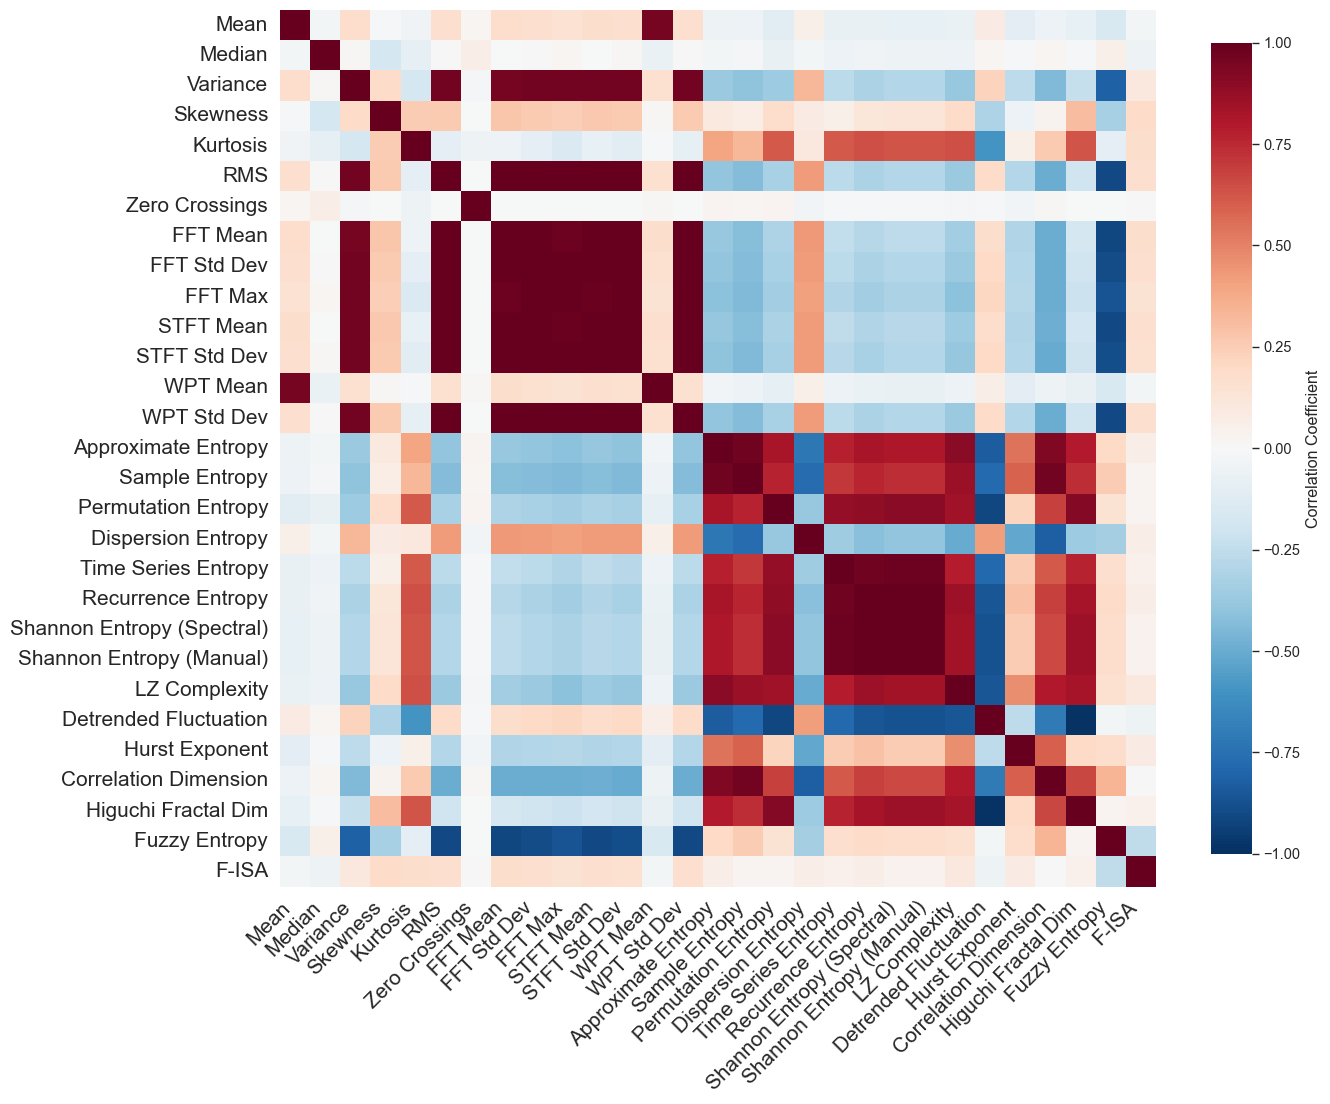

In [150]:
horizontal_cols = [col for col in df_means.columns if 'horizontal' in col]
vertical_cols = [col for col in df_means.columns if 'vertical' in col]
f_isa_col = ['F_ISA'] if 'F_ISA' in df_means.columns else []

df_horizontal_with_fisa = df_means[horizontal_cols + f_isa_col].copy()
df_vertical_with_fisa = df_means[vertical_cols + f_isa_col].copy()

df_horizontal_with_fisa.columns = clean_column_names(horizontal_cols + f_isa_col)
df_vertical_with_fisa.columns = clean_column_names(vertical_cols + f_isa_col)
# Create figure with adjusted size for better readability
fig = plt.figure(figsize=(14, 12))

# Create heatmap with improved styling
ax = fig.add_subplot(111)
corr_vertical = df_vertical_with_fisa.corr()

# Create heatmap with enhanced parameters
sns.heatmap(corr_vertical, 
            cmap='RdBu_r',
            center=0,
            vmin=-1, vmax=1,
            square=True,
            annot=False,
            cbar_kws={"shrink": .8, 
                     "label": "Correlation Coefficient",
                     "orientation": "vertical"},
            ax=ax)


# Adjust tick labels for better readability
ax.set_xticklabels(ax.get_xticklabels(), 
                   rotation=45, 
                   ha='right',
                   fontsize=15)  # Reduced from 10
ax.set_yticklabels(ax.get_yticklabels(), 
                   fontsize=15)  # Reduced from 10

# Add more space between the plot and the colorbar
plt.subplots_adjust(right=0.85)  # Added to prevent colorbar overlap

# Add a tight layout to prevent label cutoff
plt.tight_layout()

# Save with higher DPI for better quality
plt.savefig("figures/Correlation_Matrix_Features_Vertical.png", 
            dpi=300, 
            bbox_inches='tight')

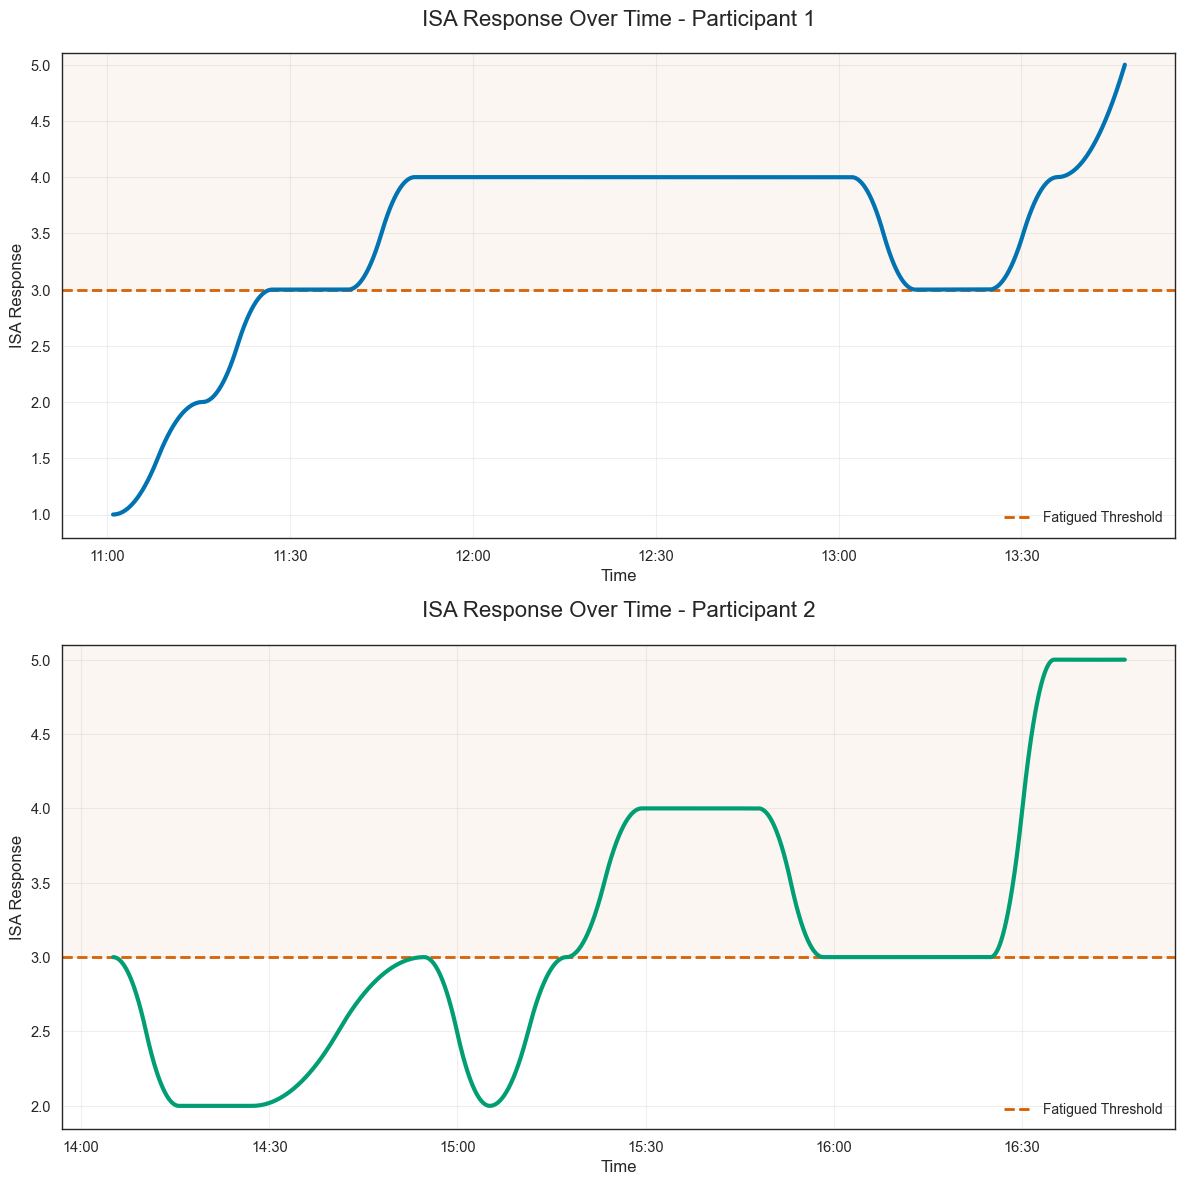

In [151]:
df_isa = [get_isa_responses(pd.read_parquet(f"data/{x}_pavlovia_raw_data.parquet").set_index(
    "timestamp"
)) for x in ["1", "2"]]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))  # Increased height for spacing

# Plot for Participant 1
sns.lineplot(data=df_isa[0], ax=ax1, color="C0", linewidth=3, zorder=3)  # Higher zorder for data line
ax1.set_title('ISA Response Over Time - Participant 1', fontsize=16, pad=20)
ax1.set_xlabel('Time', fontsize=12)
ax1.set_ylabel('ISA Response', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.axhline(y=3.0, color='C3', linestyle='--', linewidth=2, label='Fatigued Threshold', zorder=1)  # Lower zorder for threshold
ax1.axhspan(3.0, 5.1, facecolor='C3', alpha=0.05, zorder=1)  # Lower zorder for shaded area
ax1.set_ylim(bottom=None, top=5.1)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax1.legend(fontsize=10)

# Plot for Participant 2
sns.lineplot(data=df_isa[1], ax=ax2, color='C2', linewidth=3, zorder=3)  # Higher zorder for data line
ax2.set_title('ISA Response Over Time - Participant 2', fontsize=16, pad=20)
ax2.set_xlabel('Time', fontsize=12)
ax2.set_ylabel('ISA Response', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.axhline(y=3.0, color='C3', linestyle='--', linewidth=2, label='Fatigued Threshold', zorder=1)  # Lower zorder for threshold
ax2.axhspan(3.0, 5.1, facecolor='C3', alpha=0.05, zorder=1)  # Lower zorder for shaded area
ax2.set_ylim(bottom=None, top=5.1)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax2.legend(fontsize=10)

# Add spacing between subplots
plt.subplots_adjust(hspace=0.3)  # Increased spacing between subplots

# Apply tight layout
plt.tight_layout()
plt.savefig("figures/ISA_Over_Time.png")

In [ ]:
all_data = df_final.resample("1ms").nearest(limit=2).fillna(2.5)

lowcut_freq = 0.5
highcut_freq = 7.5
filter_order = 5

sos = signal.butter(filter_order, [lowcut_freq, highcut_freq], btype='band', analog=False, output='sos', fs=1000)

all_data['vertical_filtered'] = signal.sosfiltfilt(sos, all_data['vertical_value'])
all_data['horizontal_filtered'] = signal.sosfiltfilt(sos, all_data['horizontal_value'])

all_data = all_data.resample("5ms").mean()



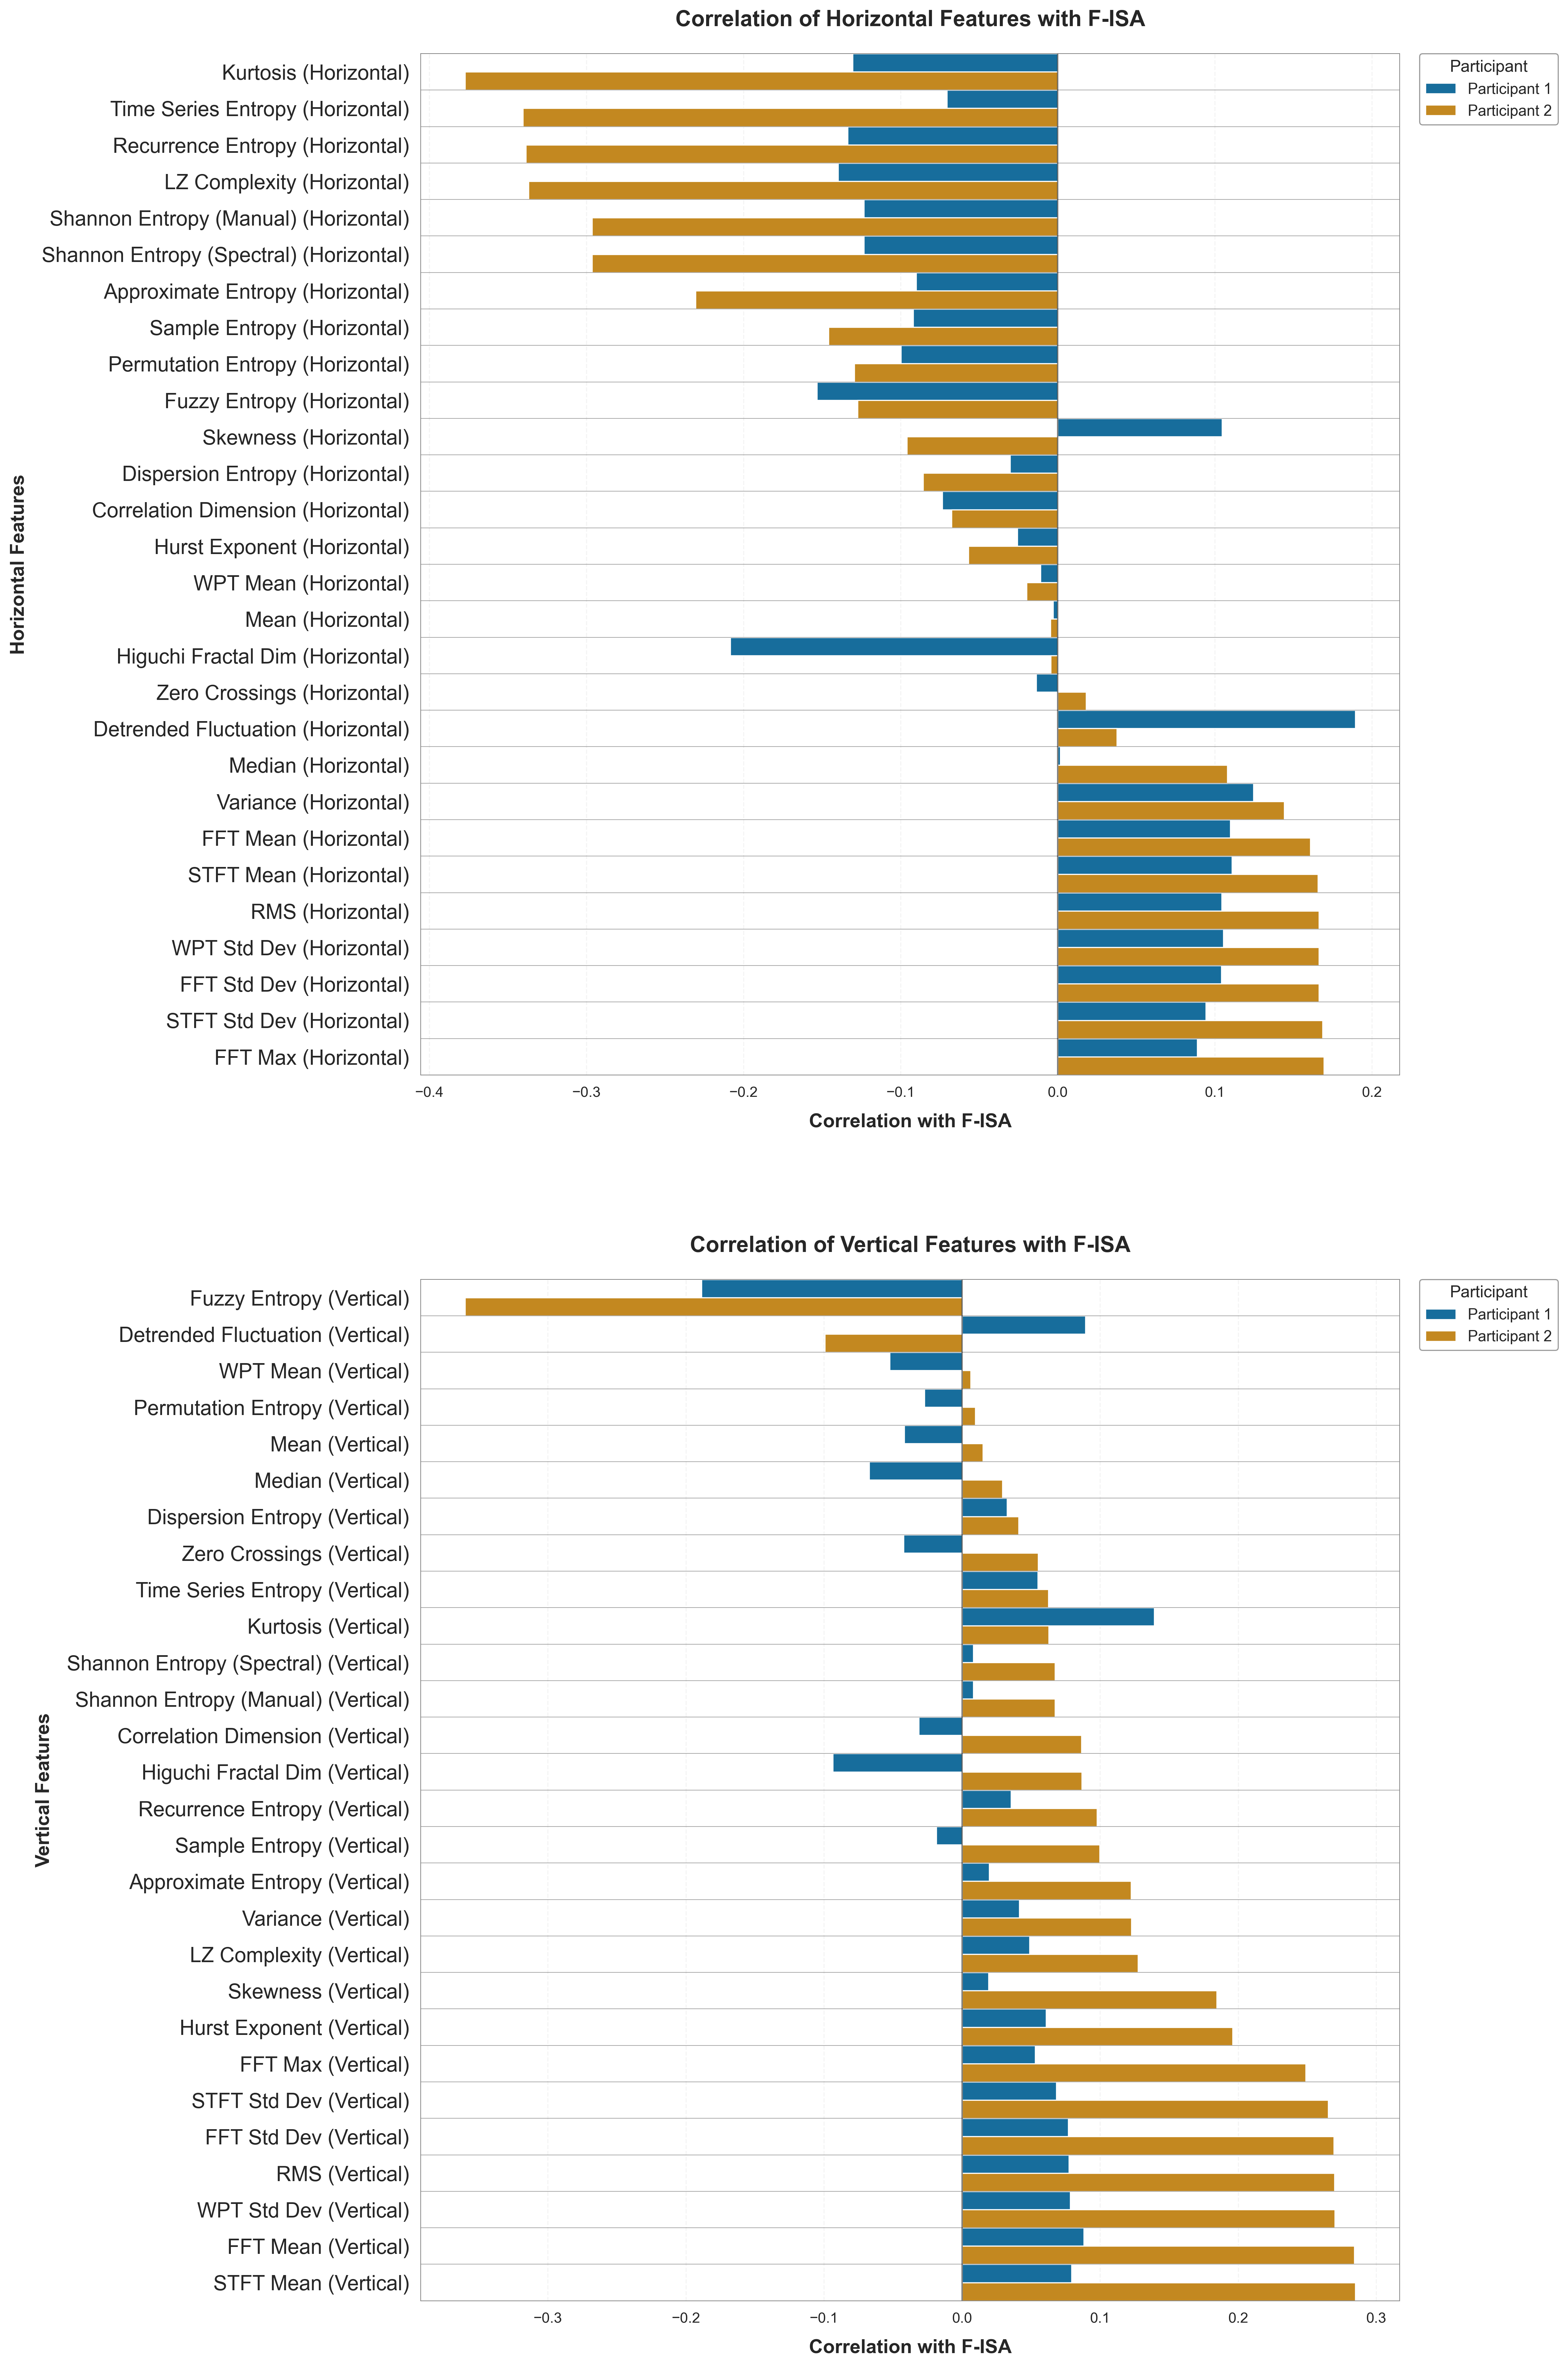

In [161]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Extract data for each participant from df_final
x_p1, y_p1 = df_final[0]  # Data for participant 1
x_p2, y_p2 = df_final[1]  # Data for participant 2

# Create DataFrames for each participant
df_p1 = x_p1.join(y_p1)
df_p2 = x_p2.join(y_p2)

# Extract the relevant columns for each participant (similar to df_means)
df_p1_means = df_p1.iloc[:, np.r_[0:56, -1]]
df_p2_means = df_p2.iloc[:, np.r_[0:56, -1]]

# Clean column names for each participant
features_p1 = df_p1_means.columns.tolist()
features_p2 = df_p2_means.columns.tolist()
features_clean_p1 = clean_column_names(features_p1, True)
features_clean_p2 = clean_column_names(features_p2, True)
df_p1_clean = df_p1_means.copy()
df_p2_clean = df_p2_means.copy()
df_p1_clean.columns = features_clean_p1
df_p2_clean.columns = features_clean_p2

# Calculate correlations with F-ISA for each participant
corr_p1 = df_p1_clean.corr()['F-ISA'].drop('F-ISA')
corr_p2 = df_p2_clean.corr()['F-ISA'].drop('F-ISA')

# Create a DataFrame to hold both sets of correlations
combined_corr = pd.DataFrame({
    'Participant 1': corr_p1,
    'Participant 2': corr_p2
})

# The original script sorted globally. We will sort subset data later.
# combined_corr = combined_corr.sort_values(by='Participant 2', ascending=True) # Global sort from original

# 1. Split data into horizontal and vertical features based on cleaned feature names
horizontal_features_clean = [idx for idx in combined_corr.index if 'horizontal' in idx.lower()]
vertical_features_clean = [idx for idx in combined_corr.index if 'vertical' in idx.lower()]

# Horizontal data
combined_corr_horizontal = combined_corr.loc[horizontal_features_clean].copy()
combined_corr_horizontal = combined_corr_horizontal.sort_values(by='Participant 2', ascending=True) # Sort this subset
combined_corr_long_horizontal = combined_corr_horizontal.reset_index().melt(
    id_vars='index',
    var_name='Participant',
    value_name='Correlation'
)

# Vertical data
combined_corr_vertical = combined_corr.loc[vertical_features_clean].copy()
combined_corr_vertical = combined_corr_vertical.sort_values(by='Participant 2', ascending=True) # Sort this subset
combined_corr_long_vertical = combined_corr_vertical.reset_index().melt(
    id_vars='index',
    var_name='Participant',
    value_name='Correlation'
)

# Set up the figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 24), dpi=300) # Adjusted figsize for two plots

# Plot for Horizontal Features
if not combined_corr_long_horizontal.empty:
    sns.barplot(
        x='Correlation',
        y='index',
        hue='Participant',
        data=combined_corr_long_horizontal,
        width=1,  # Width for the group of bars (P1+P2 for each feature)
        ax=ax1
    )

    feature_names_h = combined_corr_horizontal.index.tolist() # Get sorted feature names for this subplot
    for i in range(1, len(feature_names_h)):
        line_pos = i - 0.5
        ax1.axhline(y=line_pos, color='gray', linestyle='-', alpha=0.7, linewidth=0.5)

    ax1.axvline(x=0, color='black', linestyle='-', alpha=0.5, linewidth=1.0)
    ax1.set_xlabel('Correlation with F-ISA', fontsize=14, fontweight='bold', labelpad=10)
    ax1.set_ylabel('Horizontal Features', fontsize=14, fontweight='bold', labelpad=10) # Updated Y-label
    ax1.legend(
        title='Participant', title_fontsize=12, fontsize=11,
        bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, # Original legend placement
        frameon=True, facecolor='white', edgecolor='gray'
    )
    ax1.grid(axis='x', alpha=0.2, linestyle='--')
    for spine in ax1.spines.values():
        spine.set_visible(True)
        spine.set_color('gray')
        spine.set_linewidth(0.5)
    ax1.tick_params(axis='y', rotation=0, labelsize=15) # Adjust y-tick label size if needed
    ax1.set_title('Correlation of Horizontal Features with F-ISA', fontsize=16, fontweight='bold', pad=20) # Updated title
else:
    ax1.text(0.5, 0.5, "No horizontal features data to display", horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes, fontsize=12)
    ax1.set_title('Correlation of Horizontal Features with F-ISA', fontsize=16, fontweight='bold', pad=20)
    ax1.set_xlabel('Correlation with F-ISA', fontsize=14, fontweight='bold', labelpad=10)
    ax1.set_ylabel('Horizontal Features', fontsize=14, fontweight='bold', labelpad=10)
    # Optionally hide axis ticks/spines for empty plot if desired
    ax1.set_xticks([])
    ax1.set_yticks([])


# Plot for Vertical Features
if not combined_corr_long_vertical.empty:
    sns.barplot(
        x='Correlation',
        y='index',
        hue='Participant',
        data=combined_corr_long_vertical,
        width=1,  # Width for the group of bars (P1+P2 for each feature)
        ax=ax2
    )

    feature_names_v = combined_corr_vertical.index.tolist() # Get sorted feature names for this subplot
    for i in range(1, len(feature_names_v)):
        line_pos = i - 0.5
        ax2.axhline(y=line_pos, color='gray', linestyle='-', alpha=0.7, linewidth=0.5)

    ax2.axvline(x=0, color='black', linestyle='-', alpha=0.5, linewidth=1.0)
    ax2.set_xlabel('Correlation with F-ISA', fontsize=14, fontweight='bold', labelpad=10)
    ax2.set_ylabel('Vertical Features', fontsize=14, fontweight='bold', labelpad=10) # Updated Y-label
    ax2.legend(
        title='Participant', title_fontsize=12, fontsize=11,
        bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, # Original legend placement
        frameon=True, facecolor='white', edgecolor='gray'
    )
    ax2.grid(axis='x', alpha=0.2, linestyle='--')
    for spine in ax2.spines.values():
        spine.set_visible(True)
        spine.set_color('gray')
        spine.set_linewidth(0.5)
    ax2.tick_params(axis='y', rotation=0, labelsize=15) # Adjust y-tick label size if needed
    ax2.set_title('Correlation of Vertical Features with F-ISA', fontsize=16, fontweight='bold', pad=20) # Updated title
else:
    ax2.text(0.5, 0.5, "No vertical features data to display", horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes, fontsize=12)
    ax2.set_title('Correlation of Vertical Features with F-ISA', fontsize=16, fontweight='bold', pad=20)
    ax2.set_xlabel('Correlation with F-ISA', fontsize=14, fontweight='bold', labelpad=10)
    ax2.set_ylabel('Vertical Features', fontsize=14, fontweight='bold', labelpad=10)
    ax2.set_xticks([])
    ax2.set_yticks([])

# Adjust layout to prevent label cutoff and overlap
plt.tight_layout()
fig.subplots_adjust(hspace=0.2) # Add/adjust vertical spacing between subplots

# Save the plot with high quality
plt.savefig("figures/feature_corr_by_participant_split.png",
            bbox_inches='tight', # Ensures legends outside axes are included
            dpi=300,
            facecolor='white',
            edgecolor='none')

plt.show() # Uncomment to display in a non-notebook environment if needed

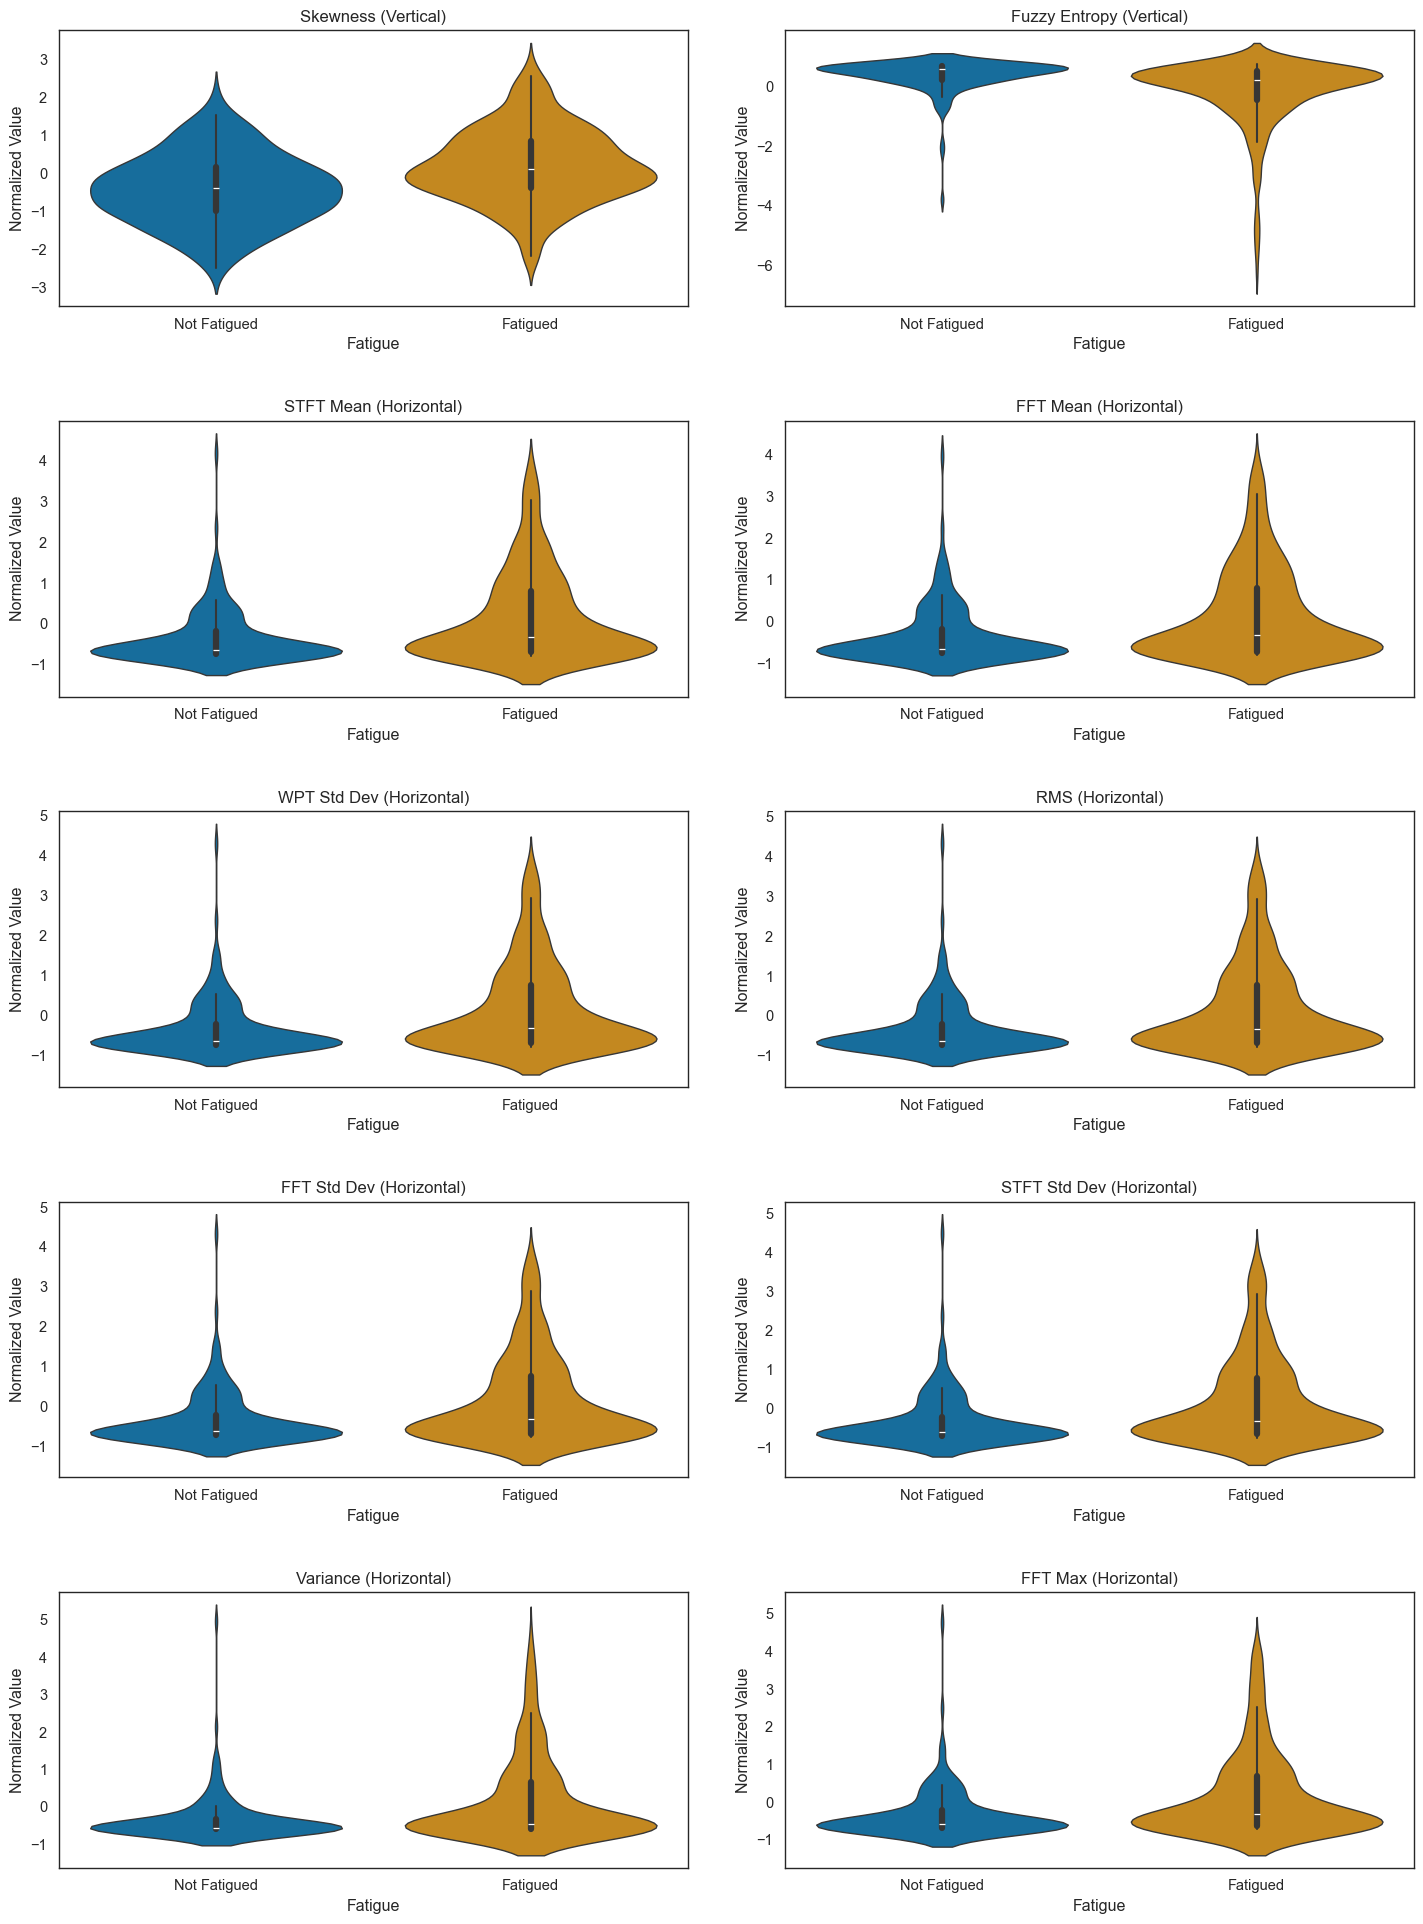

In [164]:
df_binary = df.copy().iloc[:, np.r_[0:56, -1]]
df_binary["F_ISA"] = df_binary["F_ISA"].map(lambda x: x > 3)
correlations = df_binary.corr()['F_ISA'].abs().sort_values(ascending=False)
correlations = correlations.drop('F_ISA')
top_10_features = correlations.head(10).index.tolist()

df_normalized = df_binary.copy()
scaler = StandardScaler()
df_normalized[top_10_features] = scaler.fit_transform(df_binary[top_10_features])

clean_names = clean_column_names(top_10_features, add_suffix=True)

n_features = len(top_10_features)
n_cols = 2
n_rows = int(np.ceil(n_features / n_cols))

plt.figure(figsize=(15, 4 * n_rows))

for i, (col, clean_name) in enumerate(zip(top_10_features, clean_names)):
    plt.subplot(n_rows, n_cols, i + 1)
    
    sns.violinplot(x='F_ISA', y=col, data=df_normalized, hue='F_ISA', legend=False)
    
    plt.title(clean_name, fontsize=12)
    plt.xlabel('Fatigue')
    plt.ylabel('Normalized Value')
    plt.xticks([0, 1], ['Not Fatigued', 'Fatigued'])

plt.tight_layout(pad=3.0)
plt.savefig("figures/violin.png")

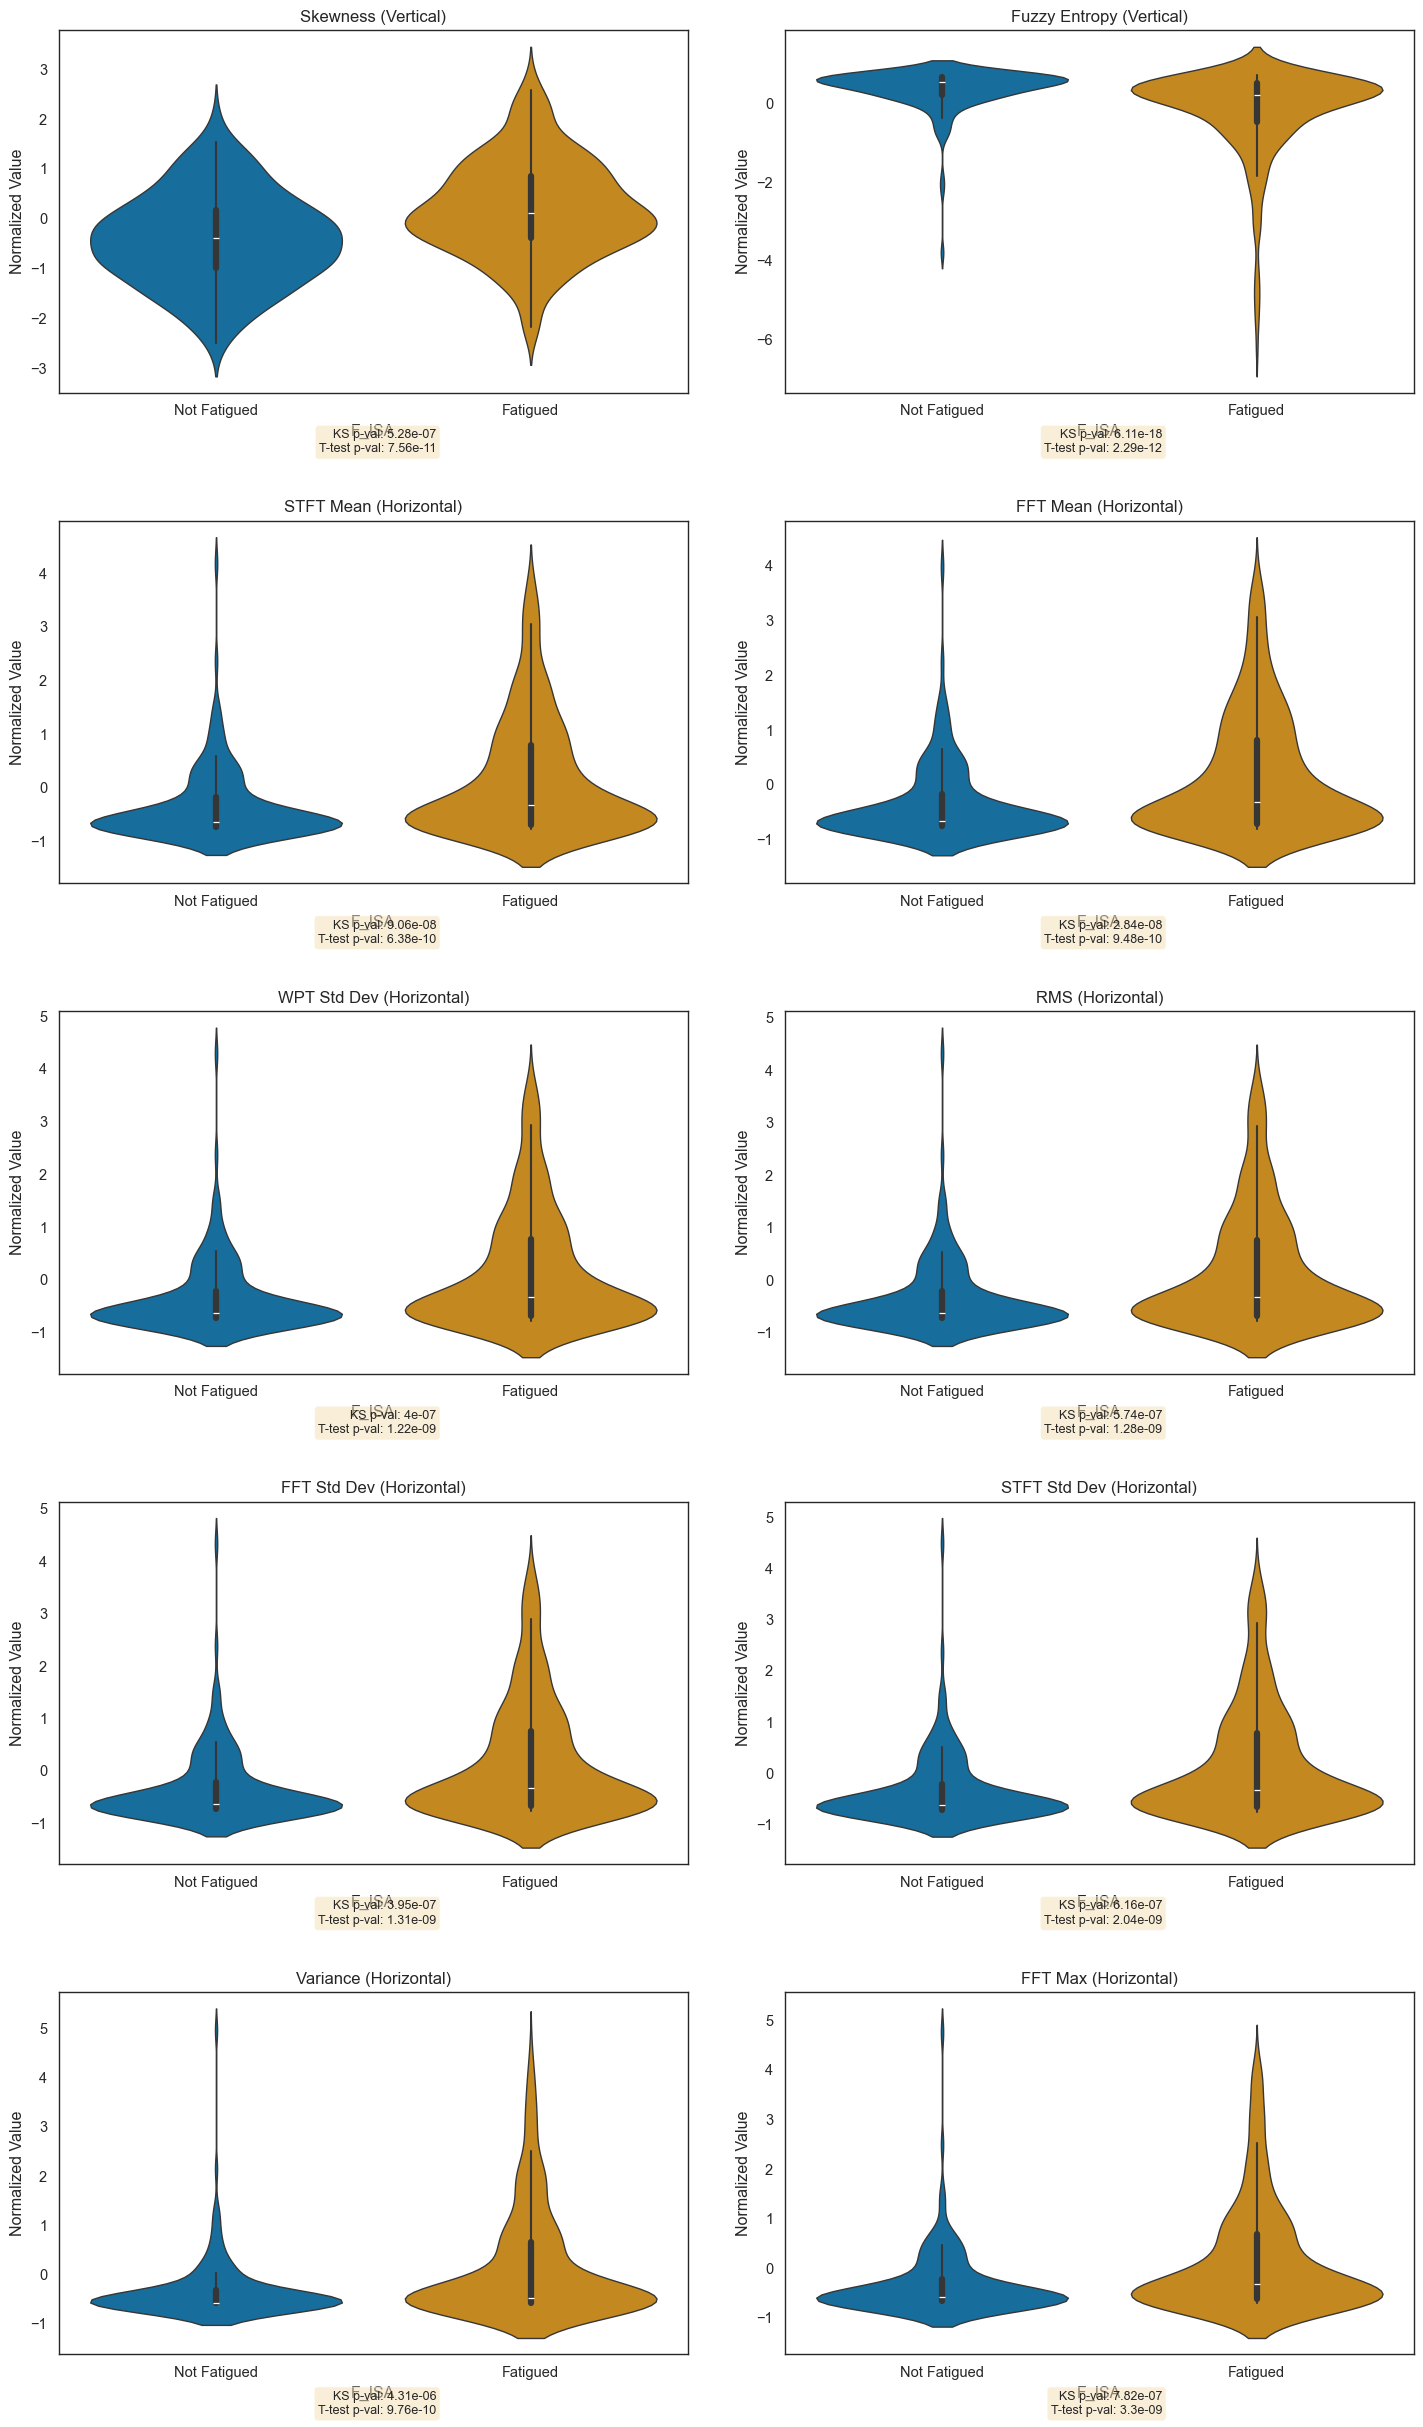

In [181]:
from scipy import stats # Make sure this import is present at the top of your notebook

n_features = len(top_10_features)
n_cols = 2
n_rows = int(np.ceil(n_features / n_cols))

plt.figure(figsize=(15, 5 * n_rows)) # Increased vertical space slightly for annotations

for i, (col, clean_name) in enumerate(zip(top_10_features, clean_names)):
    ax = plt.subplot(n_rows, n_cols, i + 1)
    
    sns.violinplot(x='F_ISA', y=col, data=df_normalized, hue='F_ISA', legend=False, ax=ax)
    
    # Prepare data for statistical tests
    group_not_fatigued = df_normalized[df_normalized['F_ISA'] == False][col]
    group_fatigued = df_normalized[df_normalized['F_ISA'] == True][col]

    # 1. Kolmogorov-Smirnov two-sample test
    # Check if both groups have data to avoid errors with empty arrays
    ks_stat, ks_p_value = "N/A", "N/A"
    if len(group_not_fatigued) > 1 and len(group_fatigued) > 1: # kstest needs at least 2 data points in each sample generally
        ks_result = stats.kstest(group_not_fatigued, group_fatigued)
        ks_p_value = ks_result.pvalue
        ks_stat = ks_result.statistic


    # 2. Independent samples t-test
    # ttest_ind assumes independent samples.
    tt_stat, tt_p_value = "N/A", "N/A"
    if len(group_not_fatigued) > 1 and len(group_fatigued) > 1:
        tt_result = stats.ttest_ind(group_not_fatigued, group_fatigued, equal_var=False) # Welch's t-test by default if variances are unequal
        tt_p_value = tt_result.pvalue
        tt_stat = tt_result.statistic

    # 3. Show the values in the plot
    annotation_text = f"KS p-val: {ks_p_value:.3g}\nT-test p-val: {tt_p_value:.3g}"
    if ks_p_value == "N/A" or tt_p_value == "N/A":
         annotation_text = f"KS p-val: {ks_p_value}\nT-test p-val: {tt_p_value}"


    # Add text annotation to the plot
    # Position the text. Adjust x, y, ha, va as needed for best fit.
    ax.text(0.6, -0.1, annotation_text,
            transform=ax.transAxes, # Position relative to axes
            fontsize=9,
            verticalalignment='top',
            horizontalalignment='right',
            bbox=dict(boxstyle='round,pad=0.3', fc='wheat', alpha=0.5))

    plt.title(clean_name, fontsize=12)
    plt.ylabel('Normalized Value')
    plt.xticks([0, 1], ['Not Fatigued', 'Fatigued'])

plt.tight_layout(pad=3.0)
plt.savefig("figures/violin_with_stats.png")
# plt.show() # Uncomment if you want to display it in a script environment

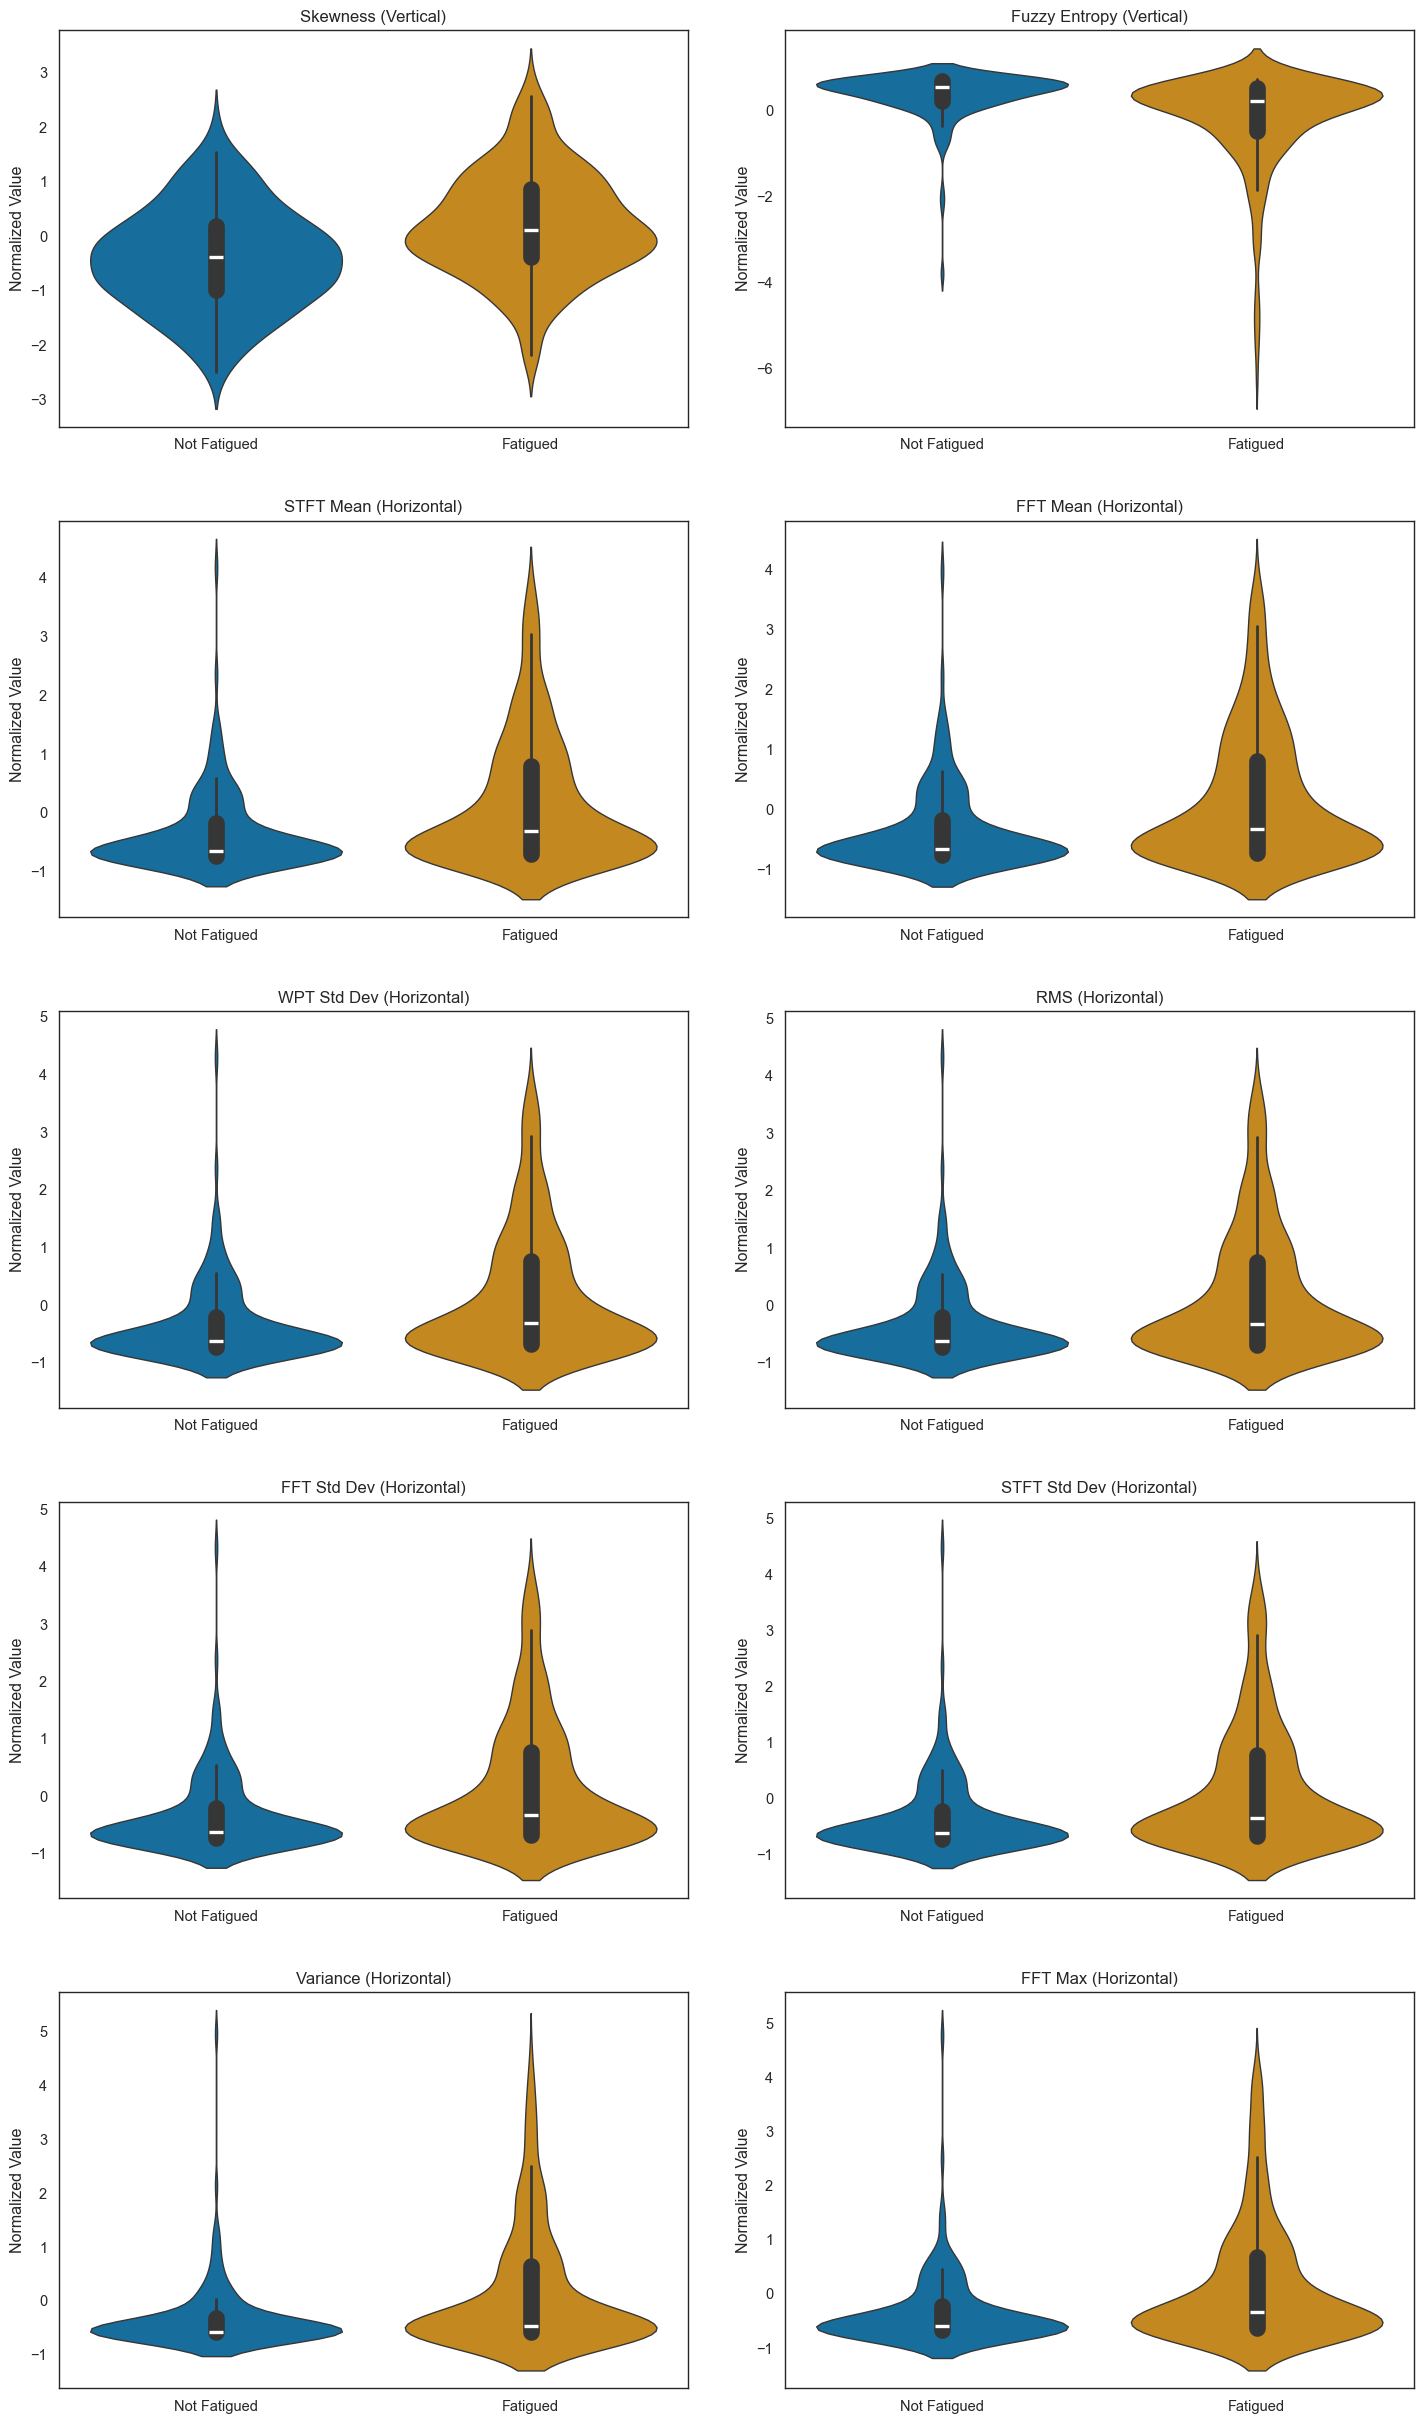

In [211]:

n_features = len(top_10_features)
n_cols = 2
n_rows = int(np.ceil(n_features / n_cols))

plt.figure(figsize=(15, 5 * n_rows)) # Increased vertical space slightly for annotations

for i, (col, clean_name) in enumerate(zip(top_10_features, clean_names)):
    ax = plt.subplot(n_rows, n_cols, i + 1)
    
    sns.violinplot(x='F_ISA', y=col, data=df_normalized, hue='F_ISA', legend=False, ax=ax, inner_kws=dict(box_width=12, whis_width=2))
    ax.set_xlabel('') # Removed the 'F_ISA' x-axis label
    
    plt.title(clean_name, fontsize=12)
    plt.ylabel('Normalized Value')
    plt.xticks([0, 1], ['Not Fatigued', 'Fatigued']) # Keep these tick labels

plt.tight_layout(pad=3.0) 
plt.savefig("figures/violin_with_stats.png")
# plt.show()

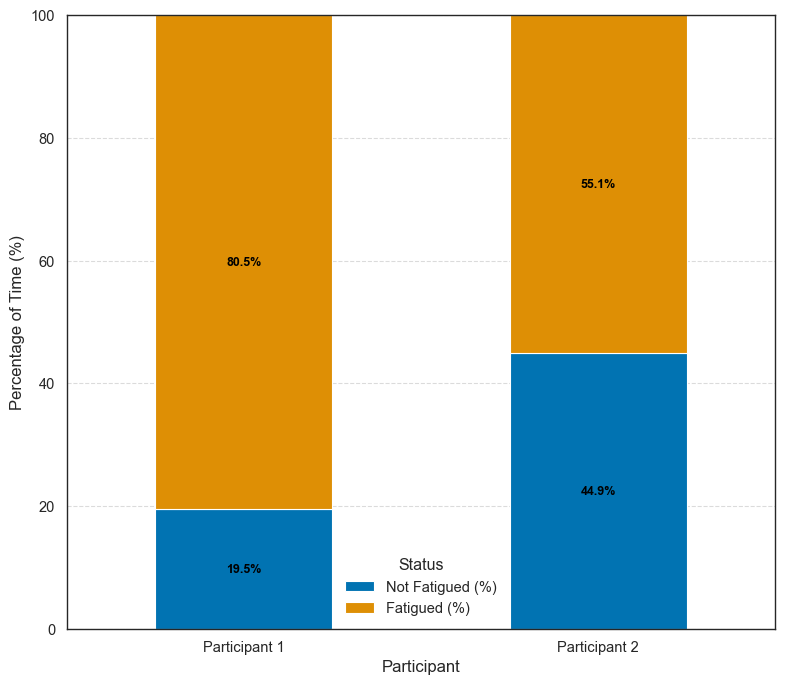

In [240]:
# This code should be placed after your existing line plot code and its plt.savefig() call.
# It assumes df_isa is already defined:
# df_isa = [get_isa_responses(pd.read_parquet(f"data/{x}_pavlovia_raw_data.parquet").set_index(
# "timestamp"
# )) for x in ["1", "2"]]
# and that import pandas as pd and import matplotlib.pyplot as plt have been executed.

# Extract ISA data for each participant
# Ensure df_isa[0] and df_isa[1] are pandas Series containing the ISA scores
isa_p1 = df_isa[0]
isa_p2 = df_isa[1]

# Determine fatigue state (True if fatigued, False if not)
is_fatigued_p1 = isa_p1 > 3
is_fatigued_p2 = isa_p2 > 3

# Calculate total number of observations for each participant
total_obs_p1 = len(isa_p1)
total_obs_p2 = len(isa_p2)

# Calculate percentage of time in each state for Participant 1
not_fatigued_pct_p1 = ((is_fatigued_p1 == False).sum() / total_obs_p1) * 100 if total_obs_p1 > 0 else 0
fatigued_pct_p1 = (is_fatigued_p1.sum() / total_obs_p1) * 100 if total_obs_p1 > 0 else 0

# Calculate percentage of time in each state for Participant 2
not_fatigued_pct_p2 = ((is_fatigued_p2 == False).sum() / total_obs_p2) * 100 if total_obs_p2 > 0 else 0
fatigued_pct_p2 = (is_fatigued_p2.sum() / total_obs_p2) * 100 if total_obs_p2 > 0 else 0

# Prepare data for the stacked bar chart
# Columns ordered for bottom-to-top stacking: Not Fatigued, then Fatigued
plot_data_stacked_bar = pd.DataFrame({
    'Not Fatigued (%)': [not_fatigued_pct_p1, not_fatigued_pct_p2],
    'Fatigued (%)': [fatigued_pct_p1, fatigued_pct_p2]
}, index=['Participant 1', 'Participant 2'])

# Create the stacked bar chart
fig_stacked_bar, ax_stacked_bar = plt.subplots(figsize=(8, 7))

# Define colors: first for 'Not Fatigued (%)', second for 'Fatigued (%)'

plot_data_stacked_bar.plot(kind='bar', stacked=True, ax=ax_stacked_bar)

ax_stacked_bar.set_xlabel('Participant', fontsize=12)
ax_stacked_bar.set_ylabel('Percentage of Time (%)', fontsize=12)
ax_stacked_bar.tick_params(axis='x', rotation=0)  # Keep participant labels horizontal
ax_stacked_bar.legend(title='Status') # Legend will use DataFrame column names
ax_stacked_bar.set_ylim(0, 100) # Y-axis represents percentage
ax_stacked_bar.grid(axis='y', linestyle='--', alpha=0.7)

# Add percentage text on each segment of the bars
for i, participant_name in enumerate(plot_data_stacked_bar.index):
    cumulative_height = 0
    # Text for 'Not Fatigued (%)' segment
    val_not_fatigued = plot_data_stacked_bar.loc[participant_name, 'Not Fatigued (%)']
    if val_not_fatigued > 1:  # Only add text if segment is reasonably large
        ax_stacked_bar.text(i, cumulative_height + val_not_fatigued / 2,
                            f"{val_not_fatigued:.1f}%",
                            ha='center', va='center', color='black', fontsize=9, fontweight='bold')
    cumulative_height += val_not_fatigued

    # Text for 'Fatigued (%)' segment
    val_fatigued = plot_data_stacked_bar.loc[participant_name, 'Fatigued (%)']
    if val_fatigued > 1:  # Only add text if segment is reasonably large
        ax_stacked_bar.text(i, cumulative_height + val_fatigued / 2,
                            f"{val_fatigued:.1f}%",
                            ha='center', va='center', color='black', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig("figures/ISA_Fatigue_Distribution_StackedBar.png")
# You might want to add plt.show() if running this interactively and want to see the plot immediately
# plt.show()

In [242]:
plot_data_stacked_bar

,Not Fatigued (%),Fatigued (%)
Participant 1,19.460056,80.539944
Participant 2,44.885307,55.114693
